In [1]:
import jax.numpy as jnp
from jax import grad, random, jit
from jax.example_libraries.optimizers import adam
from jax.nn import sigmoid
from jax.nn import relu
import numpy as np
import jax.scipy as jsc
from tqdm import tqdm
import matplotlib.pyplot as plt

# Throughout the file we are mostly using JAX
# jax.numpy (jnp) is equivalent to numpy (np) except for np.random which is separately handled by jax.random
# jax.scipy (jsc) is equivalent to scipy
# A key should be provided everytime you sample with jax.random
# Before you sample, you may need to use `rng_key, key = random.split(rng_key)` to generate a key. See the implementation for details
# The types of jax variables may not be compatible with other libraries, and you can use converter functions like float() to solve it

In [41]:
size_data = 28
d_data = size_data * size_data # the dimension of a datapoint x
d_latent = 16 # the dimension of the hidden variables in the encoder/decoder
d_z = 2 # the dimension of the latent variable z
min_prob = 1e-6
max_prob = 1 - min_prob
epochs = 100

Upload `train.txt, train_label.txt, test.txt, test_label.txt, and anomaly.txt` to the Colab notebook using the "Upload to Session Storage" button in the files panel to the left.

In [3]:
def loaddata():
    train = []
    test = []
    anomaly = []
    train_y = []
    test_y = []
    with open('train.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            train.append(jnp.array(ar))
    with open('train_label.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            train_y.append(int(line))
    with open('test.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            test.append(jnp.array(ar))
    with open('test_label.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            test_y.append(int(line))
    with open('anomaly.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            anomaly.append(jnp.array(ar))
    return train,train_y, test, test_y, anomaly

In [4]:
rng_key = random.PRNGKey(0)
ranges = [d_z*d_latent, d_latent, d_latent*d_data, d_data, d_latent*d_data, d_latent,d_z*d_latent,d_z]
ranges = np.cumsum(ranges)
d_parameters = ranges[-1]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
ranges

array([   32,    48, 12592, 13376, 25920, 25936, 25968, 25970])

In [6]:
[ranges[0]],(d_latent, d_z)

([32], (16, 2))

In [7]:
[ranges[0], ranges[1]],(d_latent)

([32, 48], 16)

In [8]:
# we packed all parameters into one vector v (dimension is d_parameters) for automatic differentiation
# v2par translates v into the parameters
def v2par(v):
    w1 = jnp.reshape(v[:ranges[0]],(d_latent, d_z))
    b1 = jnp.reshape(v[ranges[0]:ranges[1]],(d_latent))
    w2 = jnp.reshape(v[ranges[1]:ranges[2]],(d_data, d_latent))
    b2 = jnp.reshape(v[ranges[2]:ranges[3]],(d_data))
    w3 = jnp.reshape(v[ranges[3]:ranges[4]],(d_latent, d_data))
    b3 = jnp.reshape(v[ranges[4]:ranges[5]],(d_latent))
    w4 = jnp.reshape(v[ranges[5]:ranges[6]],(d_z, d_latent))
    b4 = jnp.reshape(v[ranges[6]:],(d_z))
    return w1,b1,w2,b2,w3,b3,w4,b4

In [9]:
# par2v packs all the parameters into a vector v
def par2v(w1,b1,w2,b2,w3,b3,w4,b4):
    res = jnp.append(w1, b1)
    res = jnp.append(res, w2)
    res = jnp.append(res, b2)
    res = jnp.append(res, w3)
    res = jnp.append(res, b3)
    res = jnp.append(res, w4)
    return jnp.append(res, b4)

In [202]:
# estimate the elbo given x with a single sample of \epsilon
# You need to implement something here
def f(z, w1, b1, w2, b2):
    ##### WRITE YOUR CODE HERE #####
    res = w1@z + b1
    res = w2 @ relu(res)
    res = sigmoid(res + b2)
    return res
    ##### END YOUR CODE #####
    

def g(x, w3, b3, w4, b4):

    # # res = (w4 @ relu((w3 @ x) + b3))
    # # res = relu((w3 @ x) + b3)
    
    # res = (w3 @ x)
    
    # # print(f"res.shape before relu(res + b3): {res.shape}")
    # # print(f"b3.shape: {b3.shape}")
    # res = relu(res + b3)
    
    # # print(f"res.shape before w4: {res.shape}")

    # res = w4 @ res
    # # print(f"res.shape before b4: {res.shape}")
    # res = res + b4
    
    ##### WRITE YOUR CODE HERE #####
    res = (w4 @ relu((w3 @ x) + b3)) + b4
    return res
    ##### END YOUR CODE #####


def elbo_estimator(v, epsilon, x):
    
    
    # # You may use the following line to ensure numerical stability
    x = jnp.clip(x,min_prob,max_prob)
    # ##### WRITE YOUR CODE HERE #####

    # # print(v)
    w1,b1,w2,b2,w3,b3,w4,b4 = v2par(v)

    # # print(f"w1,b1,w2,b2,w3,b3,w4,b4: {w1.shape,b1.shape,w2.shape,b2.shape,w3.shape,b3.shape,w4.shape,b4.shape}")

    # # b1 = 

    gx = g(x, w3, b3, w4, b4)
    z = 0.1*epsilon + gx
    
    # fg_term = f(z, w1, b1, w2, b2)
    fg_term = jnp.clip(f(z, w1, b1, w2, b2), min_prob, max_prob)

    j_vector_term = (x*(jnp.log(fg_term) - jnp.log(1-fg_term))) + jnp.log(1-fg_term)

    # print(f"j_vector_term.shape: {j_vector_term.shape}")
    
    j_sum = jnp.sum(j_vector_term)
    # print(f"j_sum: {j_sum}")
    # print(f"j_sum.shape: {j_sum.shape}")

    g_vector_term = -0.5*gx*gx
    # g_vector_term = 0.5*gx*gx
    g_sum = jnp.sum(g_vector_term)
    # print(f"g_sum.shape: {g_sum.shape}")
    # print(f"g_sum: {g_sum}")
    
    contants = -0.99 + jnp.log(0.01)

    elbo = j_sum + g_sum + contants
    return elbo

    # gx = g(x, w3, b3, w4, b4)
    # z = 0.1*epsilon + gx
    # fz = jnp.clip(f(z, w1, b1, w2, b2), min_prob, max_prob)
    # term1 = -0.5*jnp.dot(z,z)
    # term2 = jnp.dot(x, jnp.log(fz))
    # term3 = jnp.dot(1-x, jnp.log(1-fz))
    # term4 = 0.5*jnp.dot(epsilon, epsilon)

    # return term1 + term2 + term3 + term4
    
    ##### END YOUR CODE #####

    


In [203]:
elbo_gradient = jit(grad(elbo_estimator,argnums=(0))) # the auto-diff command in JAX

In [204]:
train, train_y, test, test_y, anomaly = loaddata()

In [205]:
len(train), len(train_y)

(500, 500)

In [206]:
train[0].shape, train_y[0]

((784,), 0)

In [207]:
# train[0]

In [208]:
# Question 3
# elbo_gradient is a function that has the same input as elbo_estimator but returns the gradients with respect to v
# Set the parameters, v and x first and call elbo_gradient
v = jnp.zeros((d_parameters,))
# rng_key = random.PRNGKey(0)
# rng_key, key = random.split(rng_key)
# v = 0.1 * random.normal(key, (d_parameters,)) # random initialization
# v.shape

x = train[1]
# x = jnp.reshape(x, (-1,1))
print(f"x.shape: {x.shape}")

epsilon = jnp.array([0.3,1.2])
# epsilon = jnp.reshape(epsilon, (-1,1))
print(f"epsilon.shape: {epsilon.shape}")


# You need to implement something here
# What is the gradient for the ELBO w.r.t. b_4 for the first datapoint in training set?
##### WRITE YOUR CODE HERE #####
# elbo = elbo_estimator(v, epsilon, x)
# elbo

e_g = elbo_gradient(v, epsilon, x)
w1,b1,w2,b2,w3,b3,w4,b4 = v2par(e_g)
# print(v)
# print(e_g)
print(b4)
# print(w1,b1,w2,b2,w3,b3,w4,b4)
##### END YOUR CODE #####

x.shape: (784,)
epsilon.shape: (2,)
[0. 0.]


In [209]:
# Question 3
# elbo_gradient is a function that has the same input as elbo_estimator but returns the gradients with respect to v
# Set the parameters, v and x first and call elbo_gradient
v = jnp.zeros((d_parameters,))

x = train[0]

epsilon = jnp.array([0.3,1.2])

e_g = elbo_gradient(v, epsilon, x)
w1,b1,w2,b2,w3,b3,w4,b4 = v2par(e_g)

print(b4)
print(v)
# print(w1,b1,w2,b2,w3,b3,w4,b4)
##### END YOUR CODE #####

[0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [210]:
train[0].shape

(784,)

In [211]:
# Question 4
# The codes here are the minimal codes for training, to answer question 4, you need to add codes after each epoch
rng_key, key = random.split(rng_key)
v = 0.1 * random.normal(key, (d_parameters,)) # random initialization
init, update, get_params = adam(1e-3)
state = init(v) # the initial state of training, which includes not only v, but also some parameters for the optimizer
step = 0
elbo_per_epoch_train = np.zeros(epochs)
elbo_per_epoch_test = np.zeros(epochs)
# for i in range(epochs):
for i in range(25):
    # train
    elbo_train_sum = 0
    for x in tqdm(train): # tqdm is a library that makes a progress bar for the loop
        rng_key, key = random.split(rng_key)
        epsilon = random.normal(key, (d_z,)) # generate epsilon for this datapoint
        grad_v = elbo_gradient(v, epsilon, x) # evaluate the gradients
        state = update(step, -grad_v, state) # update the parameters. Since we are maximizing the ELBO, we reverse the gradients here
        step += 1
        v = get_params(state) # get_params is for retrieving the parameters from state

        ##### WRITE YOUR CODE HERE #####
        elbo = elbo_estimator(v=v, epsilon=epsilon, x=x)
        elbo_train_sum += elbo
        ##### END YOUR CODE #####
    # elbo_per_epoch_train[i] = elbo_train_sum/len(train)
    
    # test
    v = get_params(state)
    elbo_test_sum = 0
    for sample in test:
      rng_key, key = random.split(rng_key)
      epsilon = random.normal(key, (d_z,))

      ##### WRITE YOUR CODE HERE #####
      elbo = elbo_estimator(v=v, epsilon=epsilon, x=sample)
      elbo_test_sum += elbo
      
      ##### END YOUR CODE #####

    elbo_per_epoch_train[i] = elbo_train_sum / len(train)
    elbo_per_epoch_test[i] = elbo_test_sum / len(test)

100%|█████████████████████████████████████████| 500/500 [00:11<00:00, 45.31it/s]


Text(0, 0.5, 'Average ELBO Value for Simplified Eqn')

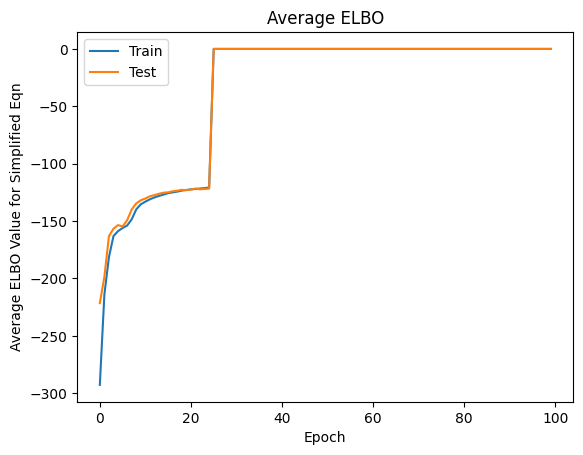

In [212]:
# Plot Solution
plt.figure()
plt.plot(range(epochs), elbo_per_epoch_train)
plt.plot(range(epochs), elbo_per_epoch_test)
plt.title("Average ELBO")
plt.legend(["Train","Test"])
plt.xlabel("Epoch")
plt.ylabel("Average ELBO Value for Simplified Eqn")

In [201]:
# elbo_per_epoch_train

Text(0, 0.5, 'Average ELBO Value')

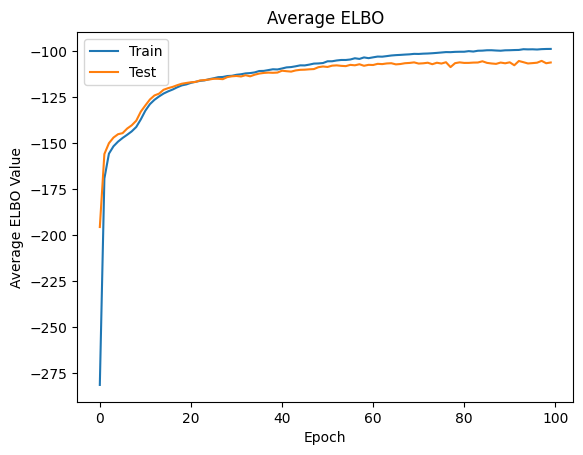

In [43]:
# Plot Solution
plt.figure()
plt.plot(range(epochs), elbo_per_epoch_train)
plt.plot(range(epochs), elbo_per_epoch_test)
plt.title("Average ELBO")
plt.legend(["Train","Test"])
plt.xlabel("Epoch")
plt.ylabel("Average ELBO Value")

In [213]:
# With the trained parameters, you can finish Question 5~8
v = get_params(state)
w1, b1, w2, b2, w3, b3, w4, b4 = v2par(v)

In [214]:
len(test), len(test_y)

(500, 500)

In [215]:
compressedData = np.zeros((len(test),2))
compressedData.shape

(500, 2)

In [216]:
compressedData[0]

array([0., 0.])

In [217]:
g(test[0], w3, b3, w4, b4).shape

(2,)

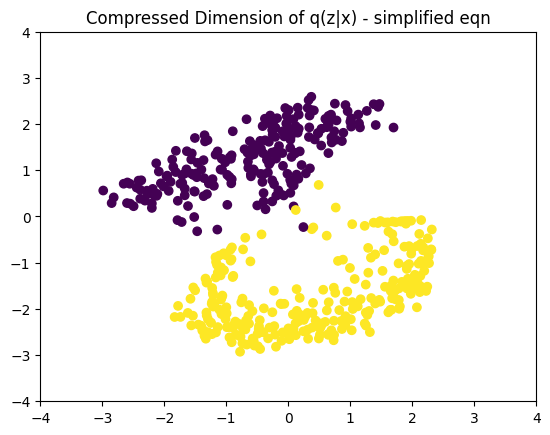

In [218]:
# Question 5
def plotCompressedData(compdata, complabels):
    compressedData = np.zeros((len(compdata),2))
    ##### WRITE YOUR CODE HERE #####
    for i, sample in enumerate(compdata):
        compressedData[i] = g(sample, w3, b3, w4, b4)
    ##### END YOUR CODE #####
    plt.figure()
    plt.scatter(compressedData[:, 0],compressedData[:,1], c = complabels)
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.title("Compressed Dimension of q(z|x) - simplified eqn")

plotCompressedData(test,test_y)

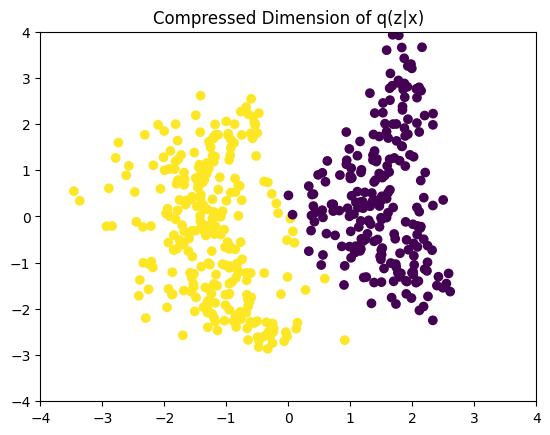

In [60]:
# Question 5
def plotCompressedData(compdata, complabels):
    compressedData = np.zeros((len(compdata),2))
    ##### WRITE YOUR CODE HERE #####
    for i, sample in enumerate(compdata):
        compressedData[i] = g(sample, w3, b3, w4, b4)
    ##### END YOUR CODE #####
    plt.figure()
    plt.scatter(compressedData[:, 0],compressedData[:,1], c = complabels)
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.title("Compressed Dimension of q(z|x)")

plotCompressedData(test,test_y)

[-1.8367852   0.57684964]
[-0.5521207 -1.5616413]
[-0.4011688  0.3522869]
[-2.021784   0.9539644]
[-0.7168728 -0.9154165]
[0.90956646 0.05849895]
[ 0.60528094 -1.2361019 ]
[-0.35366407  1.1074018 ]
[0.12173936 0.11227739]
[-0.5700724  1.8326706]


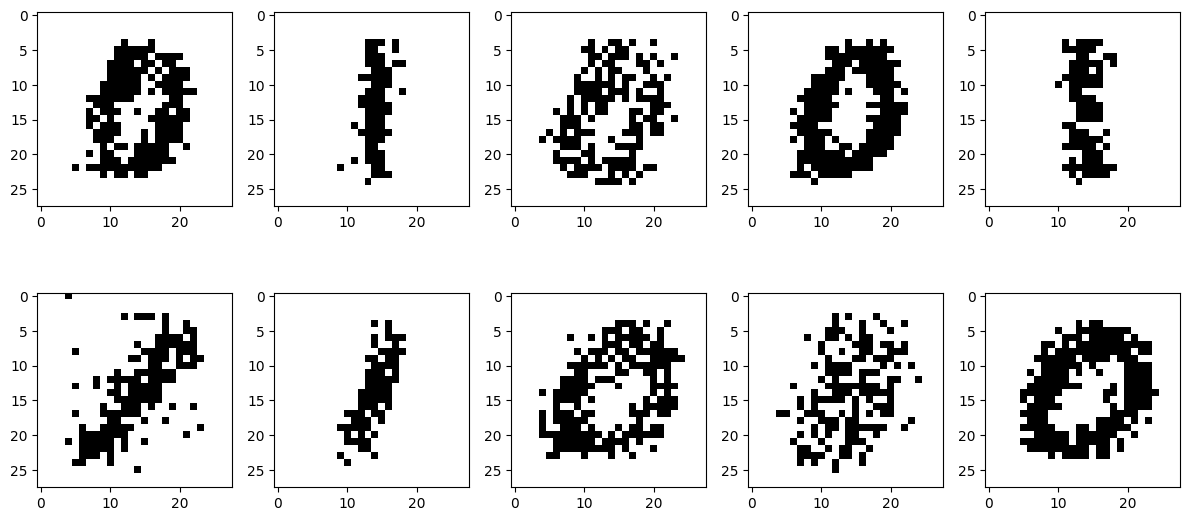

In [219]:
# Question 6

fig, axs = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2x5 subplot grid

# for im in range(10):
for im, ax in enumerate(axs.flat):  # Enumerate through subplots
    rng_key, key = random.split(rng_key) 
    
    ##### WRITE YOUR CODE HERE #####
    z = random.normal(key, (d_z,))
    print(z)
    x_z = random.bernoulli(key, f(z, w1, b1, w2, b2), (d_data,))
    ##### END YOUR CODE #####

    ax.imshow(x_z.reshape(28,28), cmap='Greys')  # Plot the image in the current subplot
    # plt.figure(im)
    # plt.imshow(x_z.reshape(28,28))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
    
    


[ 1.1994628 -0.7632709]
[-1.5676596  0.9022138]
[0.25749522 3.017279  ]
[0.8370401 0.9614436]
[ 0.2955837 -1.7223107]
[-0.953      -0.06357073]
[-0.0342904  1.0121841]
[ 0.94734657 -0.7556815 ]
[-1.6849428  0.9645187]
[0.04103208 2.1898606 ]


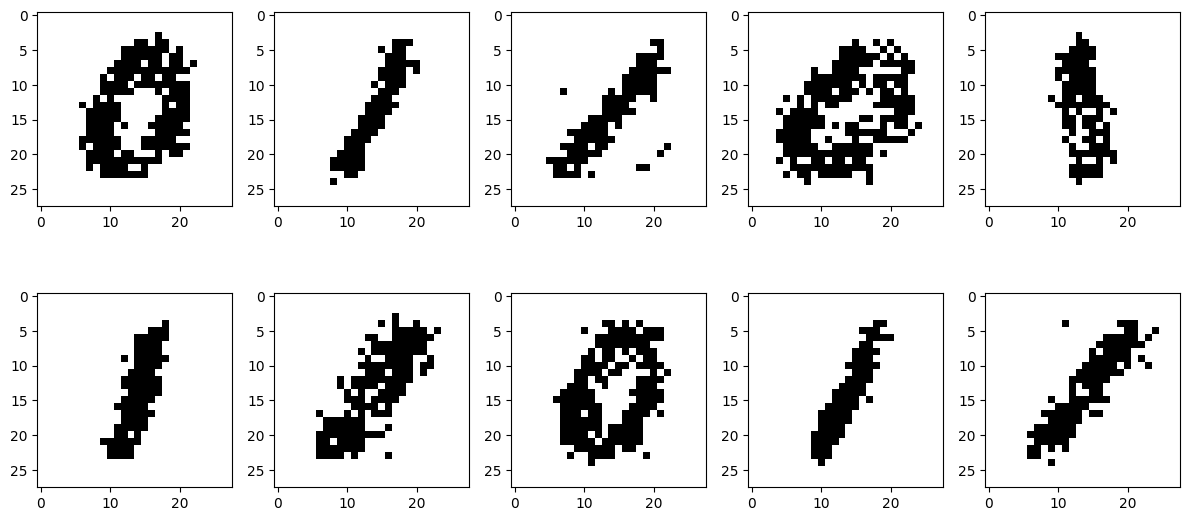

In [76]:
# Question 6

fig, axs = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2x5 subplot grid

# for im in range(10):
for im, ax in enumerate(axs.flat):  # Enumerate through subplots
    rng_key, key = random.split(rng_key) 
    
    ##### WRITE YOUR CODE HERE #####
    z = random.normal(key, (d_z,))
    print(z)
    x_z = random.bernoulli(key, f(z, w1, b1, w2, b2), (d_data,))
    ##### END YOUR CODE #####

    ax.imshow(x_z.reshape(28,28), cmap='Greys')  # Plot the image in the current subplot
    # plt.figure(im)
    # plt.imshow(x_z.reshape(28,28))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
    
    


## Experimentations; Not part of the HW

[-1.5072725  1.792554 ]
[0.579596  1.8460176]
[ 0.7076784 -1.3306713]
[-0.29310283  1.0033103 ]
[-2.0911026  1.3939244]
[-0.4573424 -0.5711259]
[ 0.19720976 -0.91631186]
[ 0.29208407 -1.5854659 ]
[0.58407176 0.9800361 ]
[ 0.6099455  -0.51742214]


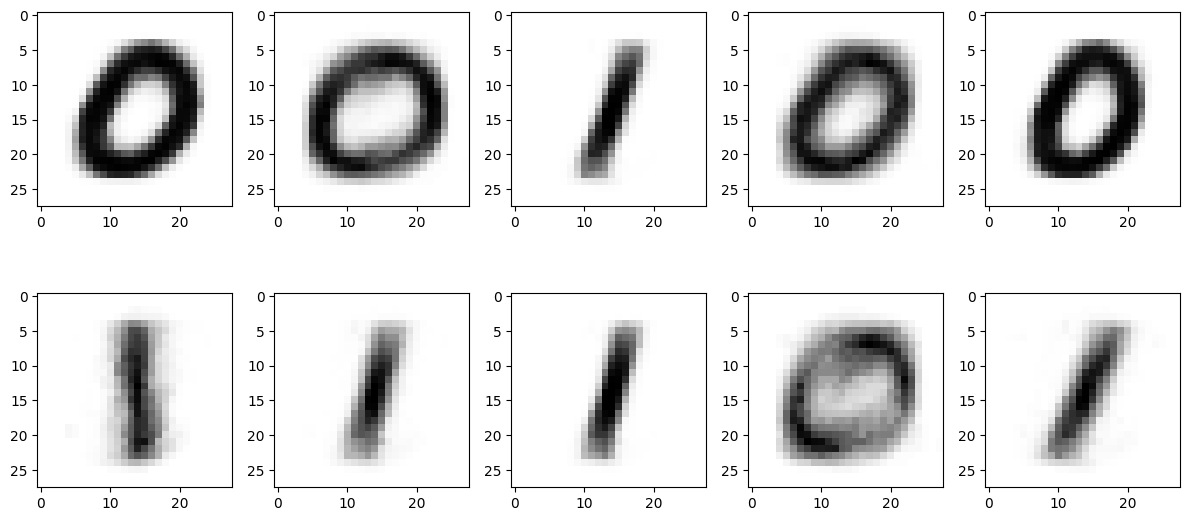

In [220]:
# Plotting without the bernoulli's

fig, axs = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2x5 subplot grid

# for im in range(10):
for im, ax in enumerate(axs.flat):  # Enumerate through subplots
    rng_key, key = random.split(rng_key) 
    
    ##### WRITE YOUR CODE HERE #####
    z = random.normal(key, (d_z,))
    print(z)
    x_z = random.bernoulli(key, f(z, w1, b1, w2, b2), (d_data,))

    f_z = f(z, w1, b1, w2, b2)
    ##### END YOUR CODE #####

    ax.imshow(f_z.reshape(28,28), cmap='Greys')  # Plot the image in the current subplot
    # plt.figure(im)
    # plt.imshow(x_z.reshape(28,28))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

[2.027869  1.4407789]
[0.89884794 0.20210807]
[-0.58140826 -1.308819  ]
[2.286669e-04 5.365132e-01]
[0.29310298 1.7107105 ]
[ 0.19905981 -0.61371094]
[-0.04286109 -0.5155953 ]
[-0.44907233  0.6127072 ]
[0.32927534 0.9638067 ]
[-1.1451892   0.10243526]


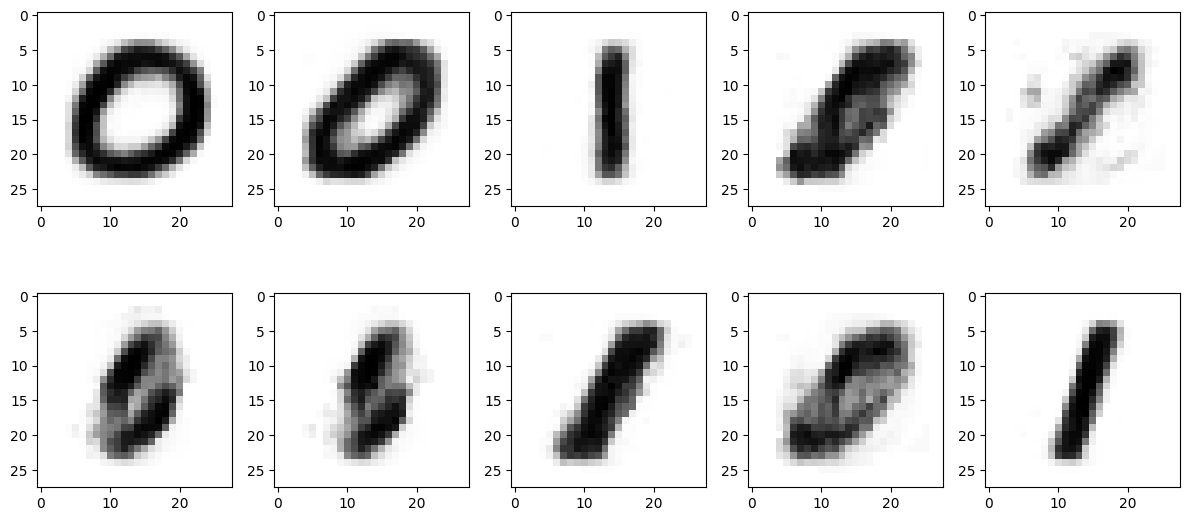

In [80]:
# Plotting without the bernoulli's

fig, axs = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2x5 subplot grid

# for im in range(10):
for im, ax in enumerate(axs.flat):  # Enumerate through subplots
    rng_key, key = random.split(rng_key) 
    
    ##### WRITE YOUR CODE HERE #####
    z = random.normal(key, (d_z,))
    print(z)
    x_z = random.bernoulli(key, f(z, w1, b1, w2, b2), (d_data,))

    f_z = f(z, w1, b1, w2, b2)
    ##### END YOUR CODE #####

    ax.imshow(f_z.reshape(28,28), cmap='Greys')  # Plot the image in the current subplot
    # plt.figure(im)
    # plt.imshow(x_z.reshape(28,28))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

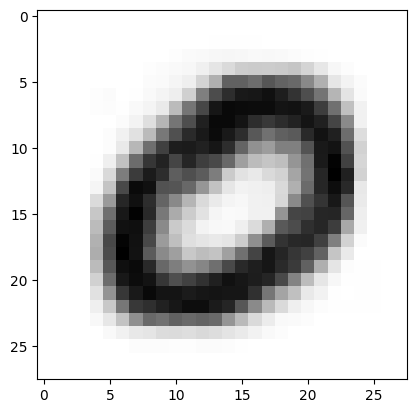

In [84]:
f_z = f(np.array([1,1]), w1, b1, w2, b2)
# plt.figure(im)
plt.imshow(f_z.reshape(28,28), cmap='Greys')

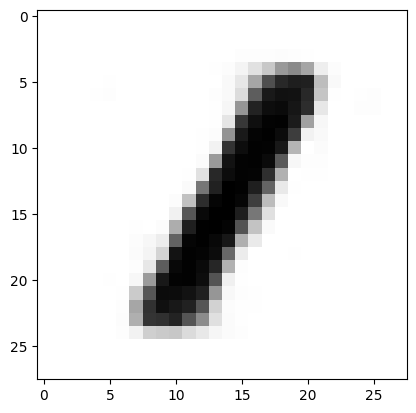

In [85]:
f_z = f(np.array([-1,1]), w1, b1, w2, b2)
# plt.figure(im)
plt.imshow(f_z.reshape(28,28), cmap='Greys')

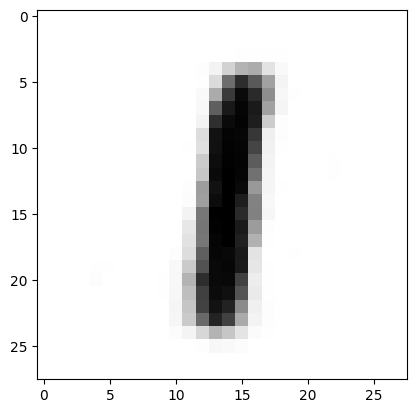

In [86]:
f_z = f(np.array([-1,-1]), w1, b1, w2, b2)
# plt.figure(im)
plt.imshow(f_z.reshape(28,28), cmap='Greys')

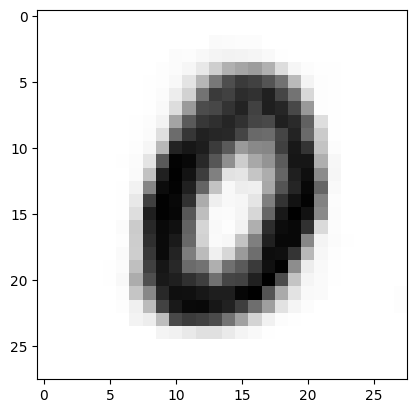

In [87]:
f_z = f(np.array([1,-1]), w1, b1, w2, b2)
# plt.figure(im)
plt.imshow(f_z.reshape(28,28), cmap='Greys')

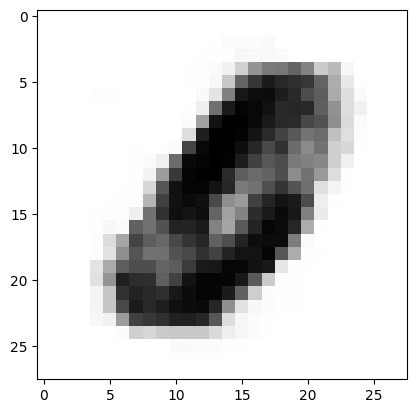

In [88]:
f_z = f(np.array([0,0]), w1, b1, w2, b2)
# plt.figure(im)
plt.imshow(f_z.reshape(28,28), cmap='Greys')

# Q7: Simplified

In [221]:
# v = 0.1 * random.normal(key, (d_parameters,)) # random initialization
# init, update, get_params = adam(1e-3)
# state = init(v) # the initial state of training, which includes not only v, but also some parameters for the optimizer
# step = 0
# elbo_per_epoch_train = np.zeros(epochs)
# elbo_per_epoch_test = np.zeros(epochs)
# for i in range(epochs):
    # train

train_LLs = []
n_sample = 75

for x in tqdm(train): # tqdm is a library that makes a progress bar for the loop
# for x in train: # tqdm is a library that makes a progress bar for the loop

    # rng_key, key = random.split(rng_key)
    # epsilon = random.normal(key, (d_z,)) # generate epsilon for this datapoint
    # grad_v = elbo_gradient(v, epsilon, x) # evaluate the gradients
    # state = update(step, -grad_v, state) # update the parameters. Since we are maximizing the ELBO, we reverse the gradients here
    # step += 1
    # v = get_params(state) # get_params is for retrieving the parameters from state

    # ##### WRITE YOUR CODE HERE #####
    # elbo = elbo_estimator(v=v, epsilon=epsilon, x=x)
    # elbo_train_sum += elbo
    ##### END YOUR CODE #####
    LL_x_samples = []
    for i in range(n_sample):
        rng_key, key = random.split(rng_key)
        z_mean = g(x, w3, b3, w4, b4)
        z_std = 0.1
        z = random.normal(key, ) * z_mean + z_std 


        ### UNLOG implementation fails ####
        # p_z_vec = jsc.stats.multivariate_normal.pdf(z, 0, 1)
        # p_z = jnp.prod(p_z_vec)
        # # print(z_mean, z, p_z_vec, p_z)

        # p_xz_vec = jsc.stats.bernoulli.pmf(x, f(z, w1, b1, w2, b2))
        # p_xz = jnp.prod(p_xz_vec)

        # q_zx_vec = jsc.stats.multivariate_normal.pdf(z, g(x, w3, b3, w4, b4), 0.1)
        # q_zx = jnp.prod(q_zx_vec)

        # print(p_z, p_xz, q_zx)
        # sample_LL = jnp.clip((p_z*p_xz)/q_zx, min_prob, max_prob)

        # print(p_z, p_xz, q_zx, sample_LL)
        
        # LL_x_sum += sample_LL

        ###LOG IMPLEMENTATION####

        # log_p_z_vec = jsc.stats.multivariate_normal.logpdf(z, 0, 1)
        log_p_z = jsc.stats.multivariate_normal.logpdf(z, jnp.zeros(2,), jnp.identity(2))
        # print(jnp.sum(log_p_z_vec), log_p_z)
        
        # log_p_z = jnp.sum(log_p_z_vec)

        
        
        # log_q_zx_vec = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01 )
        log_q_zx = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01*jnp.identity(2))
        # print(jnp.sum(log_q_zx_vec), log_p_z, g(x, w3, b3, w4, b4), log_q_zx_vec,)
        ## wrong
        # log_q_zx = jnp.sum(log_q_zx_vec)
        # log_p_z = 

        log_p_xz_vec = jsc.stats.bernoulli.logpmf(x, f(z, w1, b1, w2, b2))
        log_p_xz = jnp.sum(log_p_xz_vec)

        ###### (p_z*p_xz)/q_zx
        
        log_term = log_p_z + log_p_xz - log_q_zx 
        LL_x_samples.append(log_term)

    log_P = jsc.special.logsumexp(jnp.array(LL_x_samples)) - jnp.log(n_sample)
    # print(log_P)
    train_LLs.append(log_P)
     
        
# # elbo_per_epoch_train[i] = elbo_train_sum/len(train)

# # test
# v = get_params(state)
# elbo_test_sum = 0
# for sample in test:
#   rng_key, key = random.split(rng_key)
#   epsilon = random.normal(key, (d_z,))

#       ##### WRITE YOUR CODE HERE #####
#       elbo = elbo_estimator(v=v, epsilon=epsilon, x=sample)
#       elbo_test_sum += elbo

100%|█████████████████████████████████████████| 500/500 [02:06<00:00,  3.95it/s]


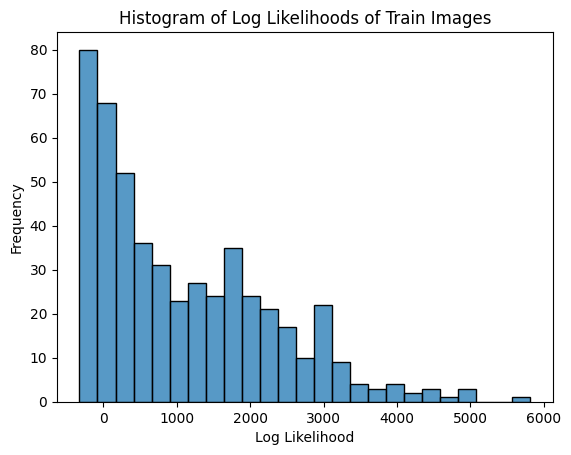

In [223]:
sns.histplot(np.array(train_LLs), bins=25, kde=False)
# plt.hist(train_LLs, bins=25)

plt.xlabel('Log Likelihood')
plt.ylabel('Frequency')
plt.title('Histogram of Log Likelihoods of Train Images')
plt.show()

In [ ]:
test_LLs = []
n_sample = 75

for x in tqdm(test): # tqdm is a library that makes a progress bar for the loop
# for x in train: # tqdm is a library that makes a progress bar for the loop
    LL_x_samples = []
    for i in range(n_sample):
        rng_key, key = random.split(rng_key)
        z_mean = g(x, w3, b3, w4, b4)
        z_std = 0.1
        z = random.normal(key, ) * z_mean + z_std 

        # log_p_z_vec = jsc.stats.multivariate_normal.logpdf(z, 0, 1)
        log_p_z = jsc.stats.multivariate_normal.logpdf(z, jnp.zeros(2,), jnp.identity(2))
        # print(jnp.sum(log_p_z_vec), log_p_z)
        
        # log_p_z = jnp.sum(log_p_z_vec)

        
        
        # log_q_zx_vec = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01 )
        log_q_zx = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01*jnp.identity(2))
        # print(jnp.sum(log_q_zx_vec), log_p_z, g(x, w3, b3, w4, b4), log_q_zx_vec,)
        ## wrong
        # log_q_zx = jnp.sum(log_q_zx_vec)
        # log_p_z = 

        log_p_xz_vec = jsc.stats.bernoulli.logpmf(x, f(z, w1, b1, w2, b2))
        log_p_xz = jnp.sum(log_p_xz_vec)

        ###### (p_z*p_xz)/q_zx
        
        log_term = log_p_z + log_p_xz - log_q_zx 
        LL_x_samples.append(log_term)

    log_P = jsc.special.logsumexp(jnp.array(LL_x_samples)) - jnp.log(n_sample)
    # print(log_P)
    test_LLs.append(log_P)

In [ ]:
import seaborn as sns

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Plot histogram for train_LLs
sns.histplot(np.array(train_LLs), bins=25, kde=False, ax=axes[0])
axes[0].set_xlabel('Log Likelihood')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Log Likelihoods of Train Images')

# Plot histogram for test_LLs
sns.histplot(np.array(test_LLs), bins=25, kde=False, ax=axes[1])
axes[1].set_xlabel('Log Likelihood')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Log Likelihoods of Test Images')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Q 7

In [128]:
# v = 0.1 * random.normal(key, (d_parameters,)) # random initialization
# init, update, get_params = adam(1e-3)
# state = init(v) # the initial state of training, which includes not only v, but also some parameters for the optimizer
# step = 0
# elbo_per_epoch_train = np.zeros(epochs)
# elbo_per_epoch_test = np.zeros(epochs)
# for i in range(epochs):
    # train

train_LLs = []
n_sample = 75

for x in tqdm(train): # tqdm is a library that makes a progress bar for the loop
# for x in train: # tqdm is a library that makes a progress bar for the loop

    # rng_key, key = random.split(rng_key)
    # epsilon = random.normal(key, (d_z,)) # generate epsilon for this datapoint
    # grad_v = elbo_gradient(v, epsilon, x) # evaluate the gradients
    # state = update(step, -grad_v, state) # update the parameters. Since we are maximizing the ELBO, we reverse the gradients here
    # step += 1
    # v = get_params(state) # get_params is for retrieving the parameters from state

    # ##### WRITE YOUR CODE HERE #####
    # elbo = elbo_estimator(v=v, epsilon=epsilon, x=x)
    # elbo_train_sum += elbo
    ##### END YOUR CODE #####
    LL_x_samples = []
    for i in range(n_sample):
        rng_key, key = random.split(rng_key)
        z_mean = g(x, w3, b3, w4, b4)
        z_std = 0.1
        z = random.normal(key, ) * z_mean + z_std 


        ### UNLOG implementation fails ####
        # p_z_vec = jsc.stats.multivariate_normal.pdf(z, 0, 1)
        # p_z = jnp.prod(p_z_vec)
        # # print(z_mean, z, p_z_vec, p_z)

        # p_xz_vec = jsc.stats.bernoulli.pmf(x, f(z, w1, b1, w2, b2))
        # p_xz = jnp.prod(p_xz_vec)

        # q_zx_vec = jsc.stats.multivariate_normal.pdf(z, g(x, w3, b3, w4, b4), 0.1)
        # q_zx = jnp.prod(q_zx_vec)

        # print(p_z, p_xz, q_zx)
        # sample_LL = jnp.clip((p_z*p_xz)/q_zx, min_prob, max_prob)

        # print(p_z, p_xz, q_zx, sample_LL)
        
        # LL_x_sum += sample_LL

        ###LOG IMPLEMENTATION####

        # log_p_z_vec = jsc.stats.multivariate_normal.logpdf(z, 0, 1)
        log_p_z = jsc.stats.multivariate_normal.logpdf(z, jnp.zeros(2,), jnp.identity(2))
        # print(jnp.sum(log_p_z_vec), log_p_z)
        
        # log_p_z = jnp.sum(log_p_z_vec)

        
        
        # log_q_zx_vec = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01 )
        log_q_zx = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01*jnp.identity(2))
        # print(jnp.sum(log_q_zx_vec), log_p_z, g(x, w3, b3, w4, b4), log_q_zx_vec,)
        ## wrong
        # log_q_zx = jnp.sum(log_q_zx_vec)
        # log_p_z = 

        log_p_xz_vec = jsc.stats.bernoulli.logpmf(x, f(z, w1, b1, w2, b2))
        log_p_xz = jnp.sum(log_p_xz_vec)

        ###### (p_z*p_xz)/q_zx
        
        log_term = log_p_z + log_p_xz - log_q_zx 
        LL_x_samples.append(log_term)

    log_P = jsc.special.logsumexp(jnp.array(LL_x_samples)) - jnp.log(n_sample)
    # print(log_P)
    train_LLs.append(log_P)
     
        
# # elbo_per_epoch_train[i] = elbo_train_sum/len(train)

# # test
# v = get_params(state)
# elbo_test_sum = 0
# for sample in test:
#   rng_key, key = random.split(rng_key)
#   epsilon = random.normal(key, (d_z,))

#       ##### WRITE YOUR CODE HERE #####
#       elbo = elbo_estimator(v=v, epsilon=epsilon, x=sample)
#       elbo_test_sum += elbo

100%|█████████████████████████████████████████| 500/500 [02:03<00:00,  4.04it/s]


In [142]:
# train_LLs

In [132]:
len(test)

500

In [133]:
test_LLs = []
n_sample = 75

for x in tqdm(test): # tqdm is a library that makes a progress bar for the loop
# for x in train: # tqdm is a library that makes a progress bar for the loop
    LL_x_samples = []
    for i in range(n_sample):
        rng_key, key = random.split(rng_key)
        z_mean = g(x, w3, b3, w4, b4)
        z_std = 0.1
        z = random.normal(key, ) * z_mean + z_std 

        # log_p_z_vec = jsc.stats.multivariate_normal.logpdf(z, 0, 1)
        log_p_z = jsc.stats.multivariate_normal.logpdf(z, jnp.zeros(2,), jnp.identity(2))
        # print(jnp.sum(log_p_z_vec), log_p_z)
        
        # log_p_z = jnp.sum(log_p_z_vec)

        
        
        # log_q_zx_vec = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01 )
        log_q_zx = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01*jnp.identity(2))
        # print(jnp.sum(log_q_zx_vec), log_p_z, g(x, w3, b3, w4, b4), log_q_zx_vec,)
        ## wrong
        # log_q_zx = jnp.sum(log_q_zx_vec)
        # log_p_z = 

        log_p_xz_vec = jsc.stats.bernoulli.logpmf(x, f(z, w1, b1, w2, b2))
        log_p_xz = jnp.sum(log_p_xz_vec)

        ###### (p_z*p_xz)/q_zx
        
        log_term = log_p_z + log_p_xz - log_q_zx 
        LL_x_samples.append(log_term)

    log_P = jsc.special.logsumexp(jnp.array(LL_x_samples)) - jnp.log(n_sample)
    # print(log_P)
    test_LLs.append(log_P)

100%|█████████████████████████████████████████| 500/500 [02:06<00:00,  3.95it/s]


In [143]:
# test_LLs

### Plotting distri

In [145]:
import seaborn as sns

In [147]:
for i in train_LLs:
    if i is None:
        print("h")

In [158]:
# train_LLs

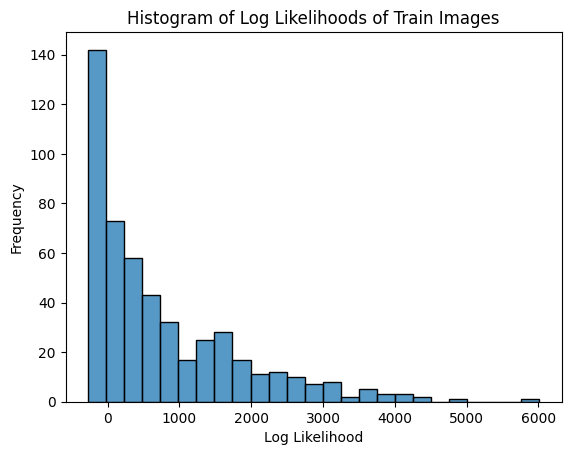

In [157]:
sns.histplot(np.array(train_LLs), bins=25, kde=False)
# plt.hist(train_LLs, bins=25)

plt.xlabel('Log Likelihood')
plt.ylabel('Frequency')
plt.title('Histogram of Log Likelihoods of Train Images')
plt.show()

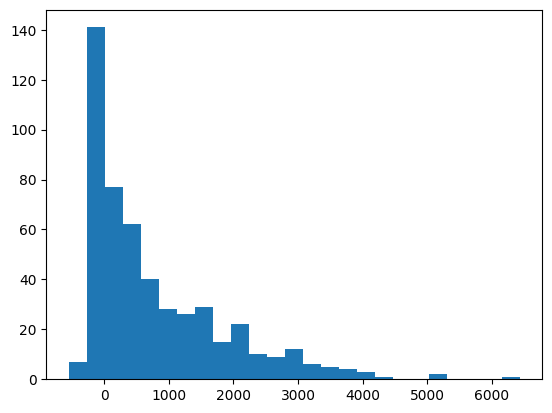

In [151]:
plt.hist(test_LLs, bins=25)
plt.show()

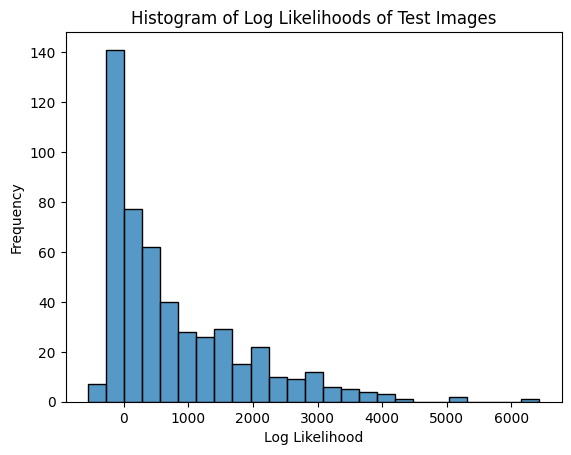

In [159]:
sns.histplot(np.array(test_LLs), bins=25, kde=False)
# plt.hist(train_LLs, bins=25)

plt.xlabel('Log Likelihood')
plt.ylabel('Frequency')
plt.title('Histogram of Log Likelihoods of Test Images')
plt.show()

In [161]:
np.array(train_LLs).mean(), np.array(test_LLs).mean()

(768.62726, 778.4709)

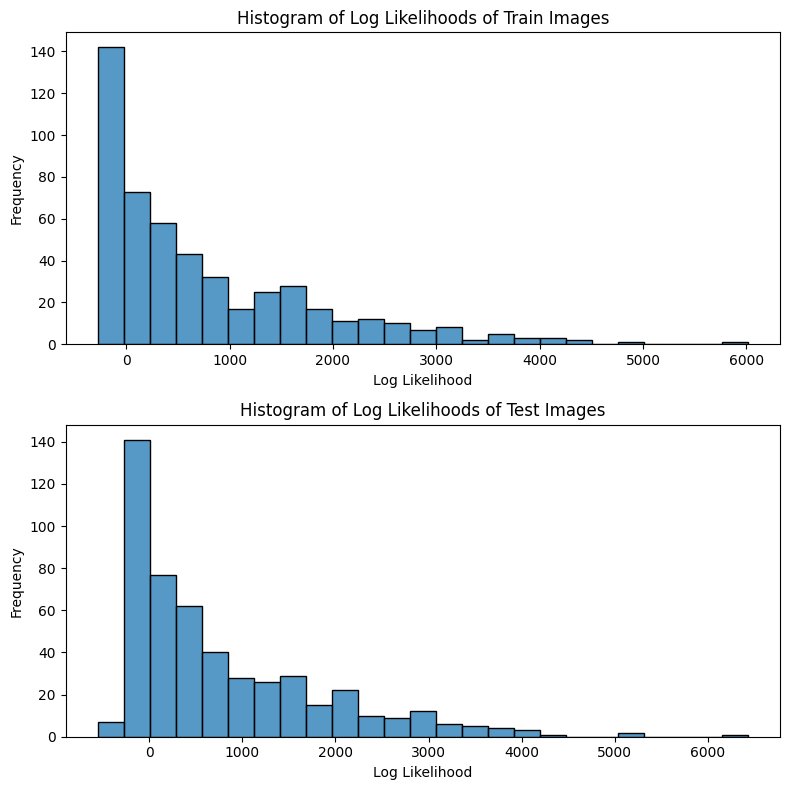

In [162]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Plot histogram for train_LLs
sns.histplot(np.array(train_LLs), bins=25, kde=False, ax=axes[0])
axes[0].set_xlabel('Log Likelihood')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Log Likelihoods of Train Images')

# Plot histogram for test_LLs
sns.histplot(np.array(test_LLs), bins=25, kde=False, ax=axes[1])
axes[1].set_xlabel('Log Likelihood')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Log Likelihoods of Test Images')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Q 8

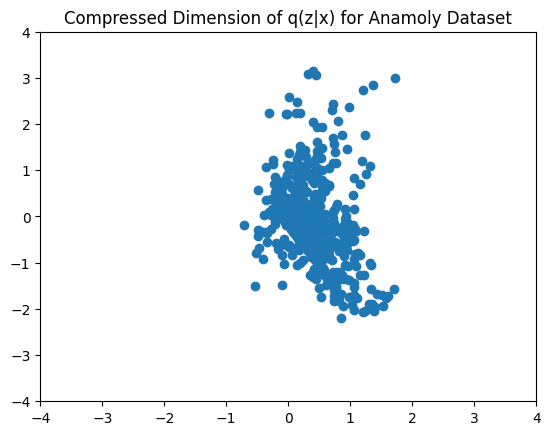

In [163]:
# Question 8
def plotCompressedData(compdata, complabels):
    compressedData = np.zeros((len(compdata),2))
    ##### WRITE YOUR CODE HERE #####
    for i, sample in enumerate(compdata):
        compressedData[i] = g(sample, w3, b3, w4, b4)
    ##### END YOUR CODE #####
    plt.figure()
    plt.scatter(compressedData[:, 0],compressedData[:,1],)
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.title("Compressed Dimension of q(z|x) for Anamoly Dataset")

plotCompressedData(anomaly,test_y)

In [164]:
anomaly_LLs = []
n_sample = 75

for x in tqdm(anomaly): # tqdm is a library that makes a progress bar for the loop
# for x in train: # tqdm is a library that makes a progress bar for the loop
    LL_x_samples = []
    for i in range(n_sample):
        rng_key, key = random.split(rng_key)
        z_mean = g(x, w3, b3, w4, b4)
        z_std = 0.1
        z = random.normal(key, ) * z_mean + z_std 

        # log_p_z_vec = jsc.stats.multivariate_normal.logpdf(z, 0, 1)
        log_p_z = jsc.stats.multivariate_normal.logpdf(z, jnp.zeros(2,), jnp.identity(2))
        # print(jnp.sum(log_p_z_vec), log_p_z)
        
        # log_p_z = jnp.sum(log_p_z_vec)

        
        
        # log_q_zx_vec = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01 )
        log_q_zx = jsc.stats.multivariate_normal.logpdf(z, g(x, w3, b3, w4, b4), 0.01*jnp.identity(2))
        # print(jnp.sum(log_q_zx_vec), log_p_z, g(x, w3, b3, w4, b4), log_q_zx_vec,)
        ## wrong
        # log_q_zx = jnp.sum(log_q_zx_vec)
        # log_p_z = 

        log_p_xz_vec = jsc.stats.bernoulli.logpmf(x, f(z, w1, b1, w2, b2))
        log_p_xz = jnp.sum(log_p_xz_vec)

        ###### (p_z*p_xz)/q_zx
        
        log_term = log_p_z + log_p_xz - log_q_zx 
        LL_x_samples.append(log_term)

    log_P = jsc.special.logsumexp(jnp.array(LL_x_samples)) - jnp.log(n_sample)
    # print(log_P)
    anomaly_LLs.append(log_P)

100%|█████████████████████████████████████████| 500/500 [02:01<00:00,  4.11it/s]


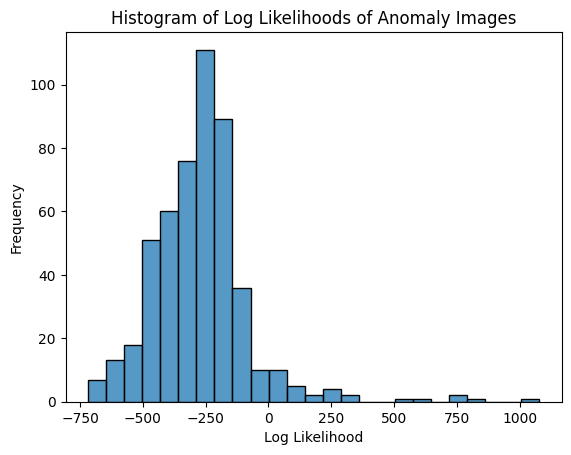

In [165]:
sns.histplot(np.array(anomaly_LLs), bins=25, kde=False)
# plt.hist(train_LLs, bins=25)

plt.xlabel('Log Likelihood')
plt.ylabel('Frequency')
plt.title('Histogram of Log Likelihoods of Anomaly Images')
plt.show()